#Herding Robotic Cats
####Constructing a single portfolio from hundreds of thousands of autonomous strategies

[Jonathan Larkin](mailto:jlarkin@quantopian.com) • Chief Investment Officer • [Quantopian Inc.](www.quantopian.com)

This notebook is the companian to a talk I gave at QuantCon Singapore on November 11, 2016.

This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances. 

In [1]:
import cvxpy as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from scipy.interpolate import griddata
from sklearn.decomposition import PCA


In [2]:
exch_tickers = ['BAC', 'C', 'HD', 'KO','LOW', 'PEP']

tickers = symbols(exch_tickers)
num_stocks = len(tickers)
start = time.time()
data = get_pricing(tickers, fields='close_price',
                   start_date='2015-04-04', end_date='2016-04-04')
end = time.time()
print "Time: %0.2f seconds." % (end - start)
returns = data.pct_change().fillna(0.0)
returns = returns - np.nanmean(returns, axis=0)

Time: 0.97 seconds.


In [3]:
pca = PCA()
features = pca.fit(returns)

In [4]:
features.components_.shape

(6, 6)

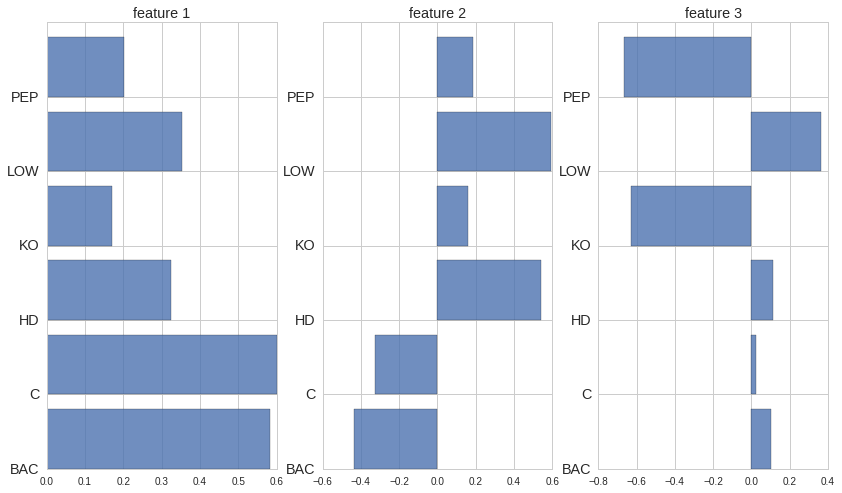

In [5]:
fig, ax = plt.subplots(1, min(num_stocks, 3))
for i in range(min(num_stocks, 3)):
    ax[i].barh(np.arange(num_stocks), features.components_[i], alpha=0.8)
    ax[i].set_yticklabels(exch_tickers, fontsize='large')
    ax[i].set_title('feature %d' % (i+1), fontsize='large')
    

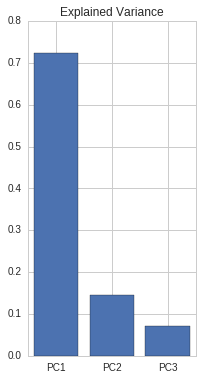

In [6]:
plt.figure(figsize=(3,6))
plt.bar(range(3), features.explained_variance_ratio_[0:3], align='center')
plt.xticks(range(3), ['PC1','PC2','PC3']);
plt.title('Explained Variance')

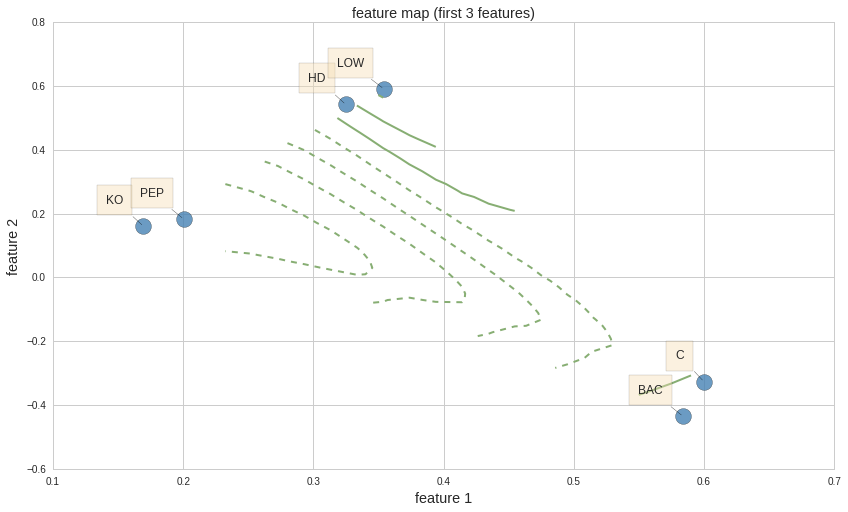

In [7]:
npts = len(features.components_[0, :])
x = features.components_[0, :]
y = features.components_[1, :]
z = features.components_[2, :]
# define grid.
xi = np.linspace(-1, 1, 100)
yi = np.linspace(-1, 1, 100)

# grid the data.
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,7,linewidths=2.0,colors='sage')
#CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.Blues, alpha=0.2)
#plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(features.components_[0, :], features.components_[1, :],
            c='steelblue', s=250, alpha=0.8, cmap=plt.cm.Blues)
plt.xlim(0.1,0.7)
plt.ylim(-0.6,0.8)
plt.title('feature map (first 3 features)', fontsize='large')

for label, x, y in zip(exch_tickers, features.components_[0, :], features.components_[1, :]):
    plt.annotate(
        label, 
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox = dict(boxstyle = 'square,pad=0.75', fc = 'wheat', alpha = 0.4),
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

plt.xlabel('feature 1', fontsize='large')
plt.ylabel('feature 2', fontsize='large')
plt.show()

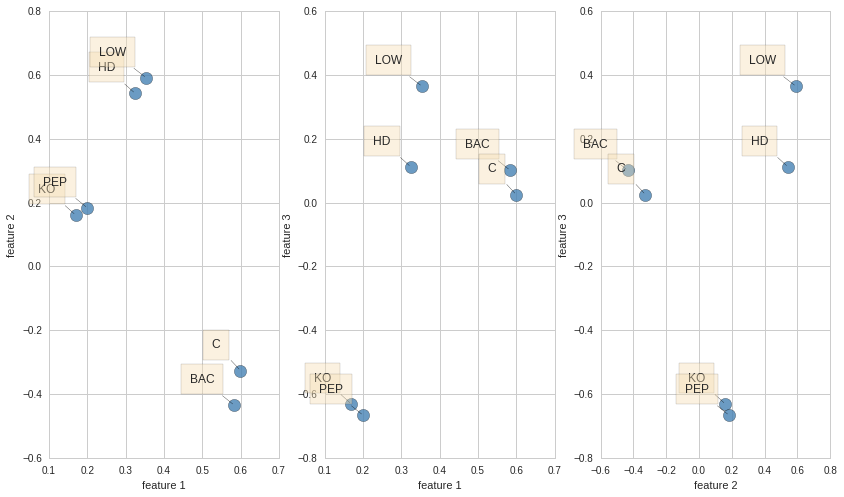

In [8]:
feature_sets = [[0,1], [0,2], [1,2]]

fig, ax = plt.subplots(1, min(num_stocks, 3))
for i in range(min(num_stocks, 3)):
    ax[i].scatter(features.components_[feature_sets[i][0], :],
               features.components_[feature_sets[i][1], :],
            c='steelblue', s=150, alpha=0.8, cmap=plt.cm.Blues)
    ax[i].set_xlabel('feature %d' % (feature_sets[i][0]+1))
    ax[i].set_ylabel('feature %d' % (feature_sets[i][1]+1))
    
    for label, x, y in zip(exch_tickers,
                           features.components_[feature_sets[i][0], :],
                           features.components_[feature_sets[i][1], :]):
        ax[i].annotate(
            label, 
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox = dict(boxstyle = 'square,pad=0.75', fc = 'wheat', alpha = 0.4),
            arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))
    


In [9]:
features_r = pca.fit_transform(returns)

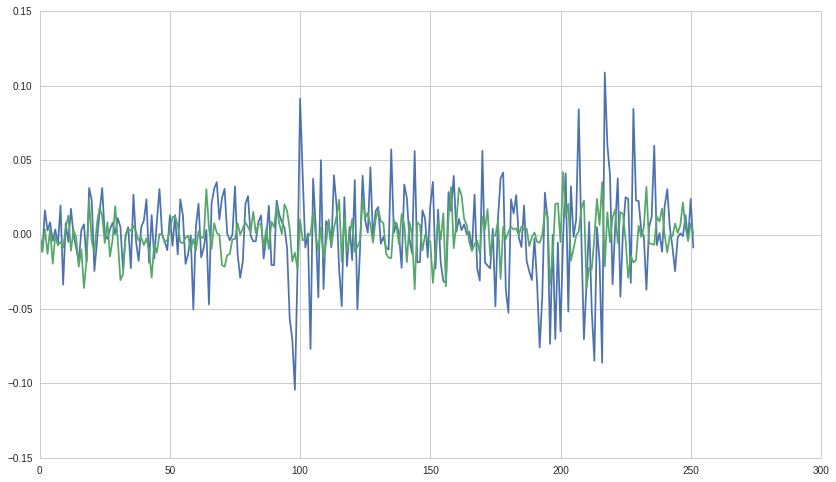

In [10]:
plt.plot(features_r[:,0:2]);

In [11]:
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import Returns, RollingLinearRegressionOfReturns

from quantopian.research import run_pipeline


In [12]:
class DataTable(CustomFactor):
    
    inputs = [USEquityPricing.close, USEquityPricing.volume]              
    window_length = 90
    outputs = ('PRICE',
               'VLTY20D',
               'VLM20DAVG')

    def compute(self, today, assets, out, close, volume):
        out.PRICE[:] = close[-1]
        out.VLTY20D[:] = 16*np.std(np.diff(np.log(close), axis=0), axis=0)
        out.VLM20DAVG[:] = np.mean(volume, axis=0)


In [13]:
pipe = Pipeline()

pipe.set_screen(StaticAssets(symbols(exch_tickers)))
data_table = DataTable(mask=StaticAssets(symbols(exch_tickers)))
pipe.add(morningstar.company_reference.legal_name.latest, 'Name')
pipe.add(morningstar.valuation.market_cap.latest, 'MCap')
pipe.add(Sector(), 'Sector')

pipe.add(data_table.PRICE,'Price' )

beta = 0.66*RollingLinearRegressionOfReturns(
    target=symbols(8554),
    returns_length=5,
    regression_length=260
).beta + 0.33*1.0

pipe.add(beta, 'Beta_SPY')


In [14]:
run_dt = '2016-08-09'
start = time.time()
res = run_pipeline(pipe, run_dt, run_dt)
end = time.time()
res.index = res.index.droplevel(0)  # drop the single date from the multi-index
res.MCap = res.MCap / 1e8
res.Sector = res.Sector.map(Sector.SECTOR_NAMES)
print "Time: %0.2f seconds." % (end - start)

Time: 15.77 seconds.


In [15]:
res

,Beta_SPY,MCap,Name,Price,Sector
Equity(700 [BAC]),1.303602,1543.990,Bank of America Corporation,15.125,FINANCIAL_SERVICES
Equity(1335 [C]),1.391961,1335.310,Citigroup Inc,45.954,FINANCIAL_SERVICES
Equity(3496 [HD]),0.959242,1694.460,The Home Depot Inc,136.210,CONSUMER_CYCLICAL
Equity(4283 [KO]),0.695212,1874.880,Coca-Cola Co,43.430,CONSUMER_DEFENSIVE
Equity(4521 [LOW]),0.950696,723.239,Lowe's Companies Inc,81.610,CONSUMER_CYCLICAL
Equity(5885 [PEP]),0.758116,1556.310,PepsiCo Inc,108.130,CONSUMER_DEFENSIVE


In [16]:
y = [12000,-10500,19000,12000,-18000,-12000]
res['y'] = y

In [17]:
expression = features.components_[0:3,:].dot(y)

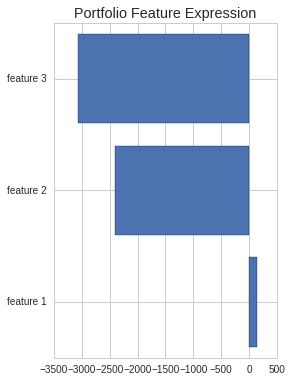

In [18]:
plt.figure(figsize=(4,6))
plt.barh(range(3), features.components_[0:3, :].dot(y), align='center');
plt.yticks(range(3), ['feature 1','feature 2','feature 3']);
plt.title('Portfolio Feature Expression', fontsize='large');


In [19]:
res

,Beta_SPY,MCap,Name,Price,Sector,y
Equity(700 [BAC]),1.303602,1543.990,Bank of America Corporation,15.125,FINANCIAL_SERVICES,12000
Equity(1335 [C]),1.391961,1335.310,Citigroup Inc,45.954,FINANCIAL_SERVICES,-10500
Equity(3496 [HD]),0.959242,1694.460,The Home Depot Inc,136.210,CONSUMER_CYCLICAL,19000
Equity(4283 [KO]),0.695212,1874.880,Coca-Cola Co,43.430,CONSUMER_DEFENSIVE,12000
Equity(4521 [LOW]),0.950696,723.239,Lowe's Companies Inc,81.610,CONSUMER_CYCLICAL,-18000
Equity(5885 [PEP]),0.758116,1556.310,PepsiCo Inc,108.130,CONSUMER_DEFENSIVE,-12000


In [20]:
res[['Name', 'y']]

,Name,y
Equity(700 [BAC]),Bank of America Corporation,12000
Equity(1335 [C]),Citigroup Inc,-10500
Equity(3496 [HD]),The Home Depot Inc,19000
Equity(4283 [KO]),Coca-Cola Co,12000
Equity(4521 [LOW]),Lowe's Companies Inc,-18000
Equity(5885 [PEP]),PepsiCo Inc,-12000


$$f: z \rightarrow y$$
$$V^T \cdot y$$



\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \sum_i{(x_i - y_i)^2} + \lambda \|V^Tx-V^Ty\|^2_2 \\
& \text{subject to}
& & u_{\text{min}} \preceq x \preceq u_{\text{max}} \\
&&& \|x\|_1  \leq  leverage_{\text{max}} \\
&&& k_{\text{min}} \preceq F^T(g + x - z)\preceq  k_{\text{max}}
\end{aligned}
\end{equation*}

In [21]:
def timeit(method):
    '''
    Decorator to time function calls
    '''
    def timed(*args, **kwargs):
        ts = time.time()
        result = method(*args, **kwargs)
        te = time.time()

        print ('%r: %2.4f sec' % \
              (method.__name__, te-ts))
        return result

    return timed

In [22]:
from scipy.stats import linregress

@timeit
def constrain_portfolio_cvxpy(
    ideal_weights,
    factor_loadings,
    min_factor_exposure,
    max_factor_exposure,
    min_weights,
    max_weights,
    max_factor_exposure_gross=None,
    current_weights=None,
    max_lev=1.0,
    turn_aversion=None,
    ideal_features=None,   
    ideal_feature_lambda=0.0):
    '''
    Portoflio optmization routine to solve
    
    min sum (x - ideal_weights)^2
             + turn_aversion'(x - current_weights)^2
             + ideal_factor_lambda * sum (F'x - b)^2
    s.t.
      F'x <= max_factor_exposure
      F'x >= min_factor_exposure
      F'|x| <= max_factor_exposure_gross
      sum(abs(x)) <= max_lev
      x >= min_weights
      x <= max_weights
    '''
    optim_scale_divisor = max(1.0, max_lev)
    
    if current_weights is None:
        current_weights = np.copy(ideal_weights)*0.0
    
    if type(turn_aversion)==float or type(turn_aversion)==int:
        turn_aversion = np.repeat(turn_aversion, len(ideal_weights))
    
    if turn_aversion is None:
        turn_aversion = np.copy(ideal_weights)*0.0
            
    num_factors = factor_loadings.shape[1] # num columns
    
    if max_factor_exposure_gross is None:
        max_factor_exposure_gross = np.repeat(max_lev*999, num_factors)
    
    if ideal_features is not None:
        num_features = ideal_features.shape[1]
        ideal_feature_exposure = ideal_features.T.dot(ideal_weights)
        b = ideal_feature_exposure/optim_scale_divisor 
    
    y = ideal_weights/optim_scale_divisor
    z = current_weights/optim_scale_divisor
    k_max = max_factor_exposure/optim_scale_divisor
    k_min = min_factor_exposure/optim_scale_divisor
    k_g_max = max_factor_exposure_gross/optim_scale_divisor
    u_min = min_weights/optim_scale_divisor
    u_max = max_weights/optim_scale_divisor
    
    n = len(y)

    x = cvx.Variable(n)
    f = factor_loadings.T*x
    f_gross = cvx.abs(factor_loadings.T)*cvx.abs(x)

    obj = cvx.Minimize(
        cvx.sum_squares(x-y) + \
        turn_aversion.T*cvx.square(x-z)
    )

    if ideal_feature_lambda > 0:
        a = ideal_features.T*x
        obj = obj + cvx.Minimize(
            ideal_feature_lambda*(cvx.sum_squares(a-b))
        )
        
    constraints = [
        cvx.norm(x, 1) <= max_lev,
        x <= u_max,
        x >= u_min,
        f <= k_max,
        f >= k_min,
        f_gross <= k_g_max
    ]

    for cons in constraints:
        if not cons.is_dcp():
            print str(cons) + ":" + str(cons.is_dcp())

    prob = cvx.Problem(obj, constraints)
    prob.solve(verbose=False)
    
    sol = np.asarray(x.value).flatten()*optim_scale_divisor
    slope, intercept, r_value, p_value, std_err = linregress(sol, y)
    turnover = sum(abs(sol-current_weights))
    
    return sol, r_value**2, turnover, factor_loadings.T.dot(sol)


In [23]:
n = len(y)
u_min = np.repeat(-20000.0, n)
u_max = np.repeat(20000.0, n)
u_max[0] = 0 # BAC 
F = (np.repeat(1.0, n)).reshape(n, 1)  # n rows, 1 column

In [24]:
result = constrain_portfolio_cvxpy(
    ideal_weights=np.array(y),
    factor_loadings=F,
    min_factor_exposure=-5000.,
    max_factor_exposure=5000.,
    min_weights=u_min,
    max_weights=u_max,
    max_lev = 65000.,
    ideal_features=features.components_[0:3, :].T,
    ideal_feature_lambda=10.0
)

'constrain_portfolio_cvxpy': 0.0208 sec


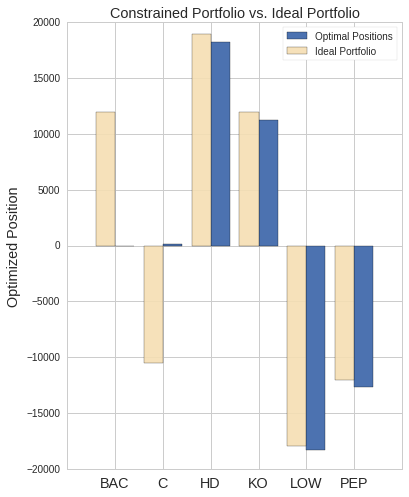

In [25]:
n = 6
data2 = np.array(y)
data1 = result[0]

bar_width = 0.4  # default: 0.8
bar_locations = np.arange(n)

plt.figure(figsize=(6,8))
plt.bar(bar_locations, data1, bar_width)
plt.bar(
    bar_locations - bar_width, 
    data2, 
    bar_width,
    color='wheat',
    alpha=0.9
)

plt.xticks(range(6), exch_tickers, fontsize='large')
plt.ylabel('Optimized Position', fontsize='large')
plt.title('Constrained Portfolio vs. Ideal Portfolio', fontsize='large')
plt.legend(labels=['Optimal Positions','Ideal Portfolio']);

In [26]:
stocks = [10,25, 50,100,250,500,1000]

times_opt = []
times = []

for n in stocks:    
    d = 500
    dat = np.random.randn(n*d).reshape(d,n)
    start = time.time()
    pca = PCA()
    pca_fit = pca.fit(dat)
    end = time.time()
    times.append(end - start)
    
    pos = np.random.randn(n)
    pos = (pos - np.mean(pos))/sum(abs(pos))
    
    F = np.repeat(1.0, n*min(75,n)).reshape(n, min(75,n))  # n rows, 1 column
    
    start = time.time()
    result = constrain_portfolio_cvxpy(
        ideal_weights=pos,
        factor_loadings=F,
        min_factor_exposure=0.05,
        max_factor_exposure=0.05,
        min_weights=-2./n,
        max_weights=2./n,
        max_lev = 1.0,
        ideal_features=pca_fit.components_[0:(min(20,n)), :].T,
        ideal_feature_lambda=10.0
    )
    end = time.time()
    times_opt.append(end - start)
    

'constrain_portfolio_cvxpy': 0.0133 sec
'constrain_portfolio_cvxpy': 0.0267 sec
'constrain_portfolio_cvxpy': 0.0705 sec
'constrain_portfolio_cvxpy': 0.2024 sec
'constrain_portfolio_cvxpy': 0.5516 sec
'constrain_portfolio_cvxpy': 1.0527 sec
'constrain_portfolio_cvxpy': 1.5798 sec


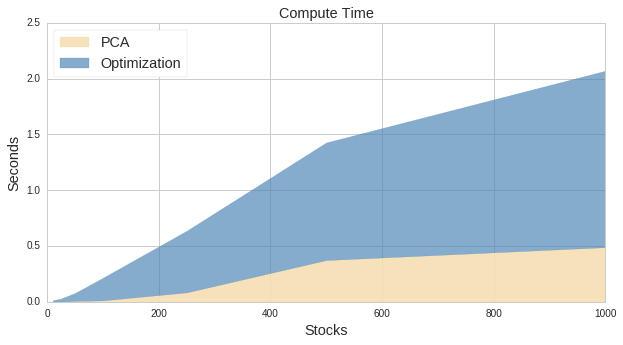

In [27]:
plt.figure(figsize=(10,5))
plt.fill_between(stocks, 0, times,color='wheat',alpha=0.90);
plt.fill_between(stocks, times, np.array(times)+np.array(times_opt),
                 color='steelblue',alpha=0.66);
plt.title('Compute Time', fontsize='large')
plt.ylabel('Seconds', fontsize='large')
plt.xlabel('Stocks', fontsize='large');
plt.legend(labels=['PCA','Optimization'], fontsize='large', loc=2);